In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.optimize import minimize
from collections import Counter

In [3]:
def Chi2XtoInf(x, k: int):
    return scipy.stats.chi2(k).sf(x)

In [4]:
def Count(sample):
    c = Counter(sample)
    return c

def Heights(counts, n):
    cur_h = 0
    heights = dict()
    for cur_key in counts:
        frequence = counts[cur_key] / n
        heights[cur_key] = cur_h + frequence
        cur_h += frequence
        
    return heights

In [5]:
def PlotUniform(x: np.array):
    y = np.linspace(0, 1, len(x))
    plt.plot(x, y)
    
def EmpericalFunction(sample, x, heights):
    n = len(sample)
    y = [heights[sample_i] for sample_i in sample]
    plt.step(sample, y, where='post')

In [6]:
def GenerateSampleWithM(nums):
    sample = []
    for i in range(len(nums)):
        tmp = [i] * nums[i]
        sample += tmp
    return sample

nums = [5, 8, 6, 12, 14, 18, 11, 6, 13, 7]
sample = GenerateSampleWithM(nums)
print(sample)

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9]


## a)

## Проверка по χ²

In [7]:
def DeltaChi2(nums, p):
    s = 0
    for i in range(len(nums)):
        s += 0.1 * (nums[i] - 10) ** 2
    return s

### p-value для χ²

In [8]:
p_value1 = Chi2XtoInf(DeltaChi2(nums, 0.1), 9)
print("p-value для χ² = ", p_value1)

p-value для χ² =  0.058984030544419454


## Проверка по Колмогорову

In [44]:
def KolmogorovDelta(args, sample, n, func):
    h_last_iter = 0
    max_delta = -1
    counts = Count(sample)
    heights = Heights(counts, n)
    
    for x in heights:
        f = func(x, args)
        print(x, f, heights[x])
        print(f - heights[x])
        print(f - h_last_iter)
        max_delta = max(max_delta, max(abs(f - heights[x]), abs(f - h_last_iter)))
        h_last_iter = heights[x]
        
    return max_delta * np.sqrt(n)

In [45]:
delta_wave = KolmogorovDelta((np.mean(sample), Sigma(sample)), sample, n, ProbabilityFunctionWrap)
print(delta_wave)

0 0.029090374767740727 0.05
-0.020909625232259275
0.029090374767740727
1 0.06717078964413262 0.13
-0.06282921035586739
0.017170789644132614
2 0.13565217948950464 0.19
-0.05434782051049536
0.0056521794895046384
3 0.2410500597208515 0.31
-0.0689499402791485
0.0510500597208515
4 0.3798807917285216 0.45
-0.07011920827147838
0.06988079172852163
5 0.5363891919159295 0.63
-0.09361080808407052
0.08638919191592948
6 0.6873936211910706 0.74
-0.05260637880892938
0.05739362119107061
7 0.8120863729763096 0.8
0.012086372976309545
0.0720863729763096
8 0.9002094229932911 0.93
-0.02979057700670895
0.10020942299329105
9 0.9535097353536752 1.0
-0.046490264646324775
0.023509735353675176
1.0020942299329105


In [10]:
def Linear(x, args):
    a, b = args
    return (x - a) / (b - a)

def KolmogorovCd(x):
    s = 0
    N = 100
    for i in range(1, N):
        s += (-1) ** i * np.exp(-2 * i * i * x * x)
    return 1 + 2 * s

### p-value для Колмогорова

In [11]:
n = 100
kolmog_delta = KolmogorovDelta((0, 9), sample, n, Linear)
p_value2 = 1 - KolmogorovCd(kolmog_delta)
print('p-value для критерия Колмогорова = ', p_value2)

p-value для критерия Колмогорова =  0.032851885438597406


## b)

## Проверка c помощью χ²

### Минимизация

In [12]:
intervals = [[-np.inf, 1]]
for i in range(8):
    intervals.append([i + 1, i + 2])
intervals.append([9, np.inf])

In [13]:
def ProbabilityDensity(x, t1, t2):
    return 1 / np.sqrt(2 * np.pi) / t2 * np.exp(-(x - t1) ** 2 / (t2 * t2) / 2)

def ProbabilityFunction(x, t1, t2):
    return scipy.integrate.quad(ProbabilityDensity, x[0], x[-1], args=(t1, t2))[0]

In [14]:
def LikelihoodFunction(x):
    mean = x[0]
    sigma = x[1]
    pows = [5, 8, 6, 12, 14, 18, 11, 6, 13, 7]
    intervals = [[-np.inf, 1]]
    for i in range(8):
        intervals.append([i + 1, i + 2])
    intervals.append([9, np.inf])
    res = 1
    for i in range(len(intervals)):
        res *= ProbabilityFunction(intervals[i], mean, sigma) ** pows[i]
    
    return -res

In [15]:
x0 = [5, 1]
result = minimize(LikelihoodFunction, x0, method='Nelder-Mead')
mean, sigma = result.x
print('Точки минимума функции правдоподобия')
print('Cреднее =', mean, 'sigma =',sigma)

Точки минимума функции правдоподобия
Cреднее = 5.289633051826962 sigma = 2.679530687575016


In [16]:
def DeltaChiSecond(mean, sigma, sample, intervals):
    counts = [Count(sample)[i] for i in Count(sample)]
    s = 0
    for i in range(len(counts)):
        np = n * ProbabilityFunction(intervals[i], mean, sigma)
        tmp = (counts[i] - np) ** 2 / np
        s += tmp
    return s

### p-value для χ²

In [17]:
delta = DeltaChiSecond(mean, sigma, sample, intervals)
p_value_b_chi = Chi2XtoInf(delta, 7)
print('p-value для χ² = ', p_value_b_chi)

p-value для χ² =  0.2000369256902222


## Проверка по Колмогорову

In [18]:
def ModulateNormal(mean, sigma, n):
    s = np.random.normal(mean, sigma, n).astype(int)
    s[s > 9] = 9
    s[s < 0] = 0
    s = np.sort(s)
    return s

def GaussGenerateSamples(mean, sigma, N = 1000):
    return [ModulateNormal(mean, sigma, n) for _ in range(N)]

In [19]:
def Sigma(sample, n = 100):
    return np.sqrt(n / (n - 1) * np.var(sample))

In [20]:
def ProbabilityFunctionWrap(x, args):
    mean, sigma = args
    args = [-np.inf, x]
    return ProbabilityFunction(args, mean, sigma)
    #return scipy.stats.norm(mean, sigma).cdf(x)

In [21]:
def ParametricBootstrapForKolmogorov(sample):
    mean = np.mean(sample)
    sigma = Sigma(sample)
    N = 1000
    generated =  GaussGenerateSamples(mean, sigma, N)
    n = len(sample)
    
    delta_wave = KolmogorovDelta((mean, sigma), sample, n, ProbabilityFunctionWrap)
    print('delta_wave = ', delta_wave)
    
    delts = np.array([])
    for cur_sample in generated:
        cur_mean = np.mean(cur_sample)
        cur_sigma = Sigma(cur_sample)
        d = KolmogorovDelta((cur_mean, cur_sigma), cur_sample, n, ProbabilityFunctionWrap)
        delts = np.append(delts, d)

    return len(delts[delts > delta_wave]) / N
    

### p-value для Колмогорова

In [22]:
p_value = ParametricBootstrapForKolmogorov(sample)
print('p-value для Колмогорова = ', p_value)

delta_wave =  1.0020942299329105
p-value для Колмогорова =  0.866


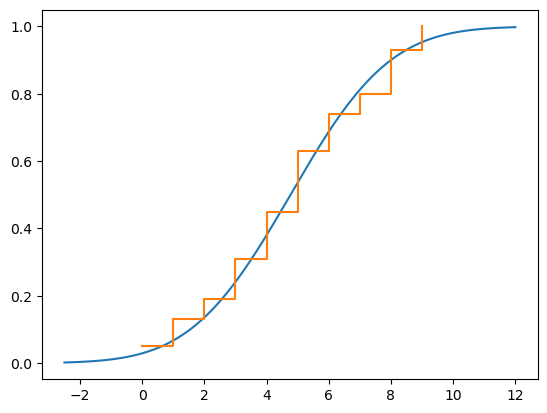

In [57]:
x = np.linspace(-2.5, 12, 1000)
y = [ProbabilityFunctionWrap(i, (np.mean(sample), Sigma(sample))) for i in x]
plt.plot(x, y)

counts = Count(sample)
heights = Heights(counts, 100)

EmpericalFunction(sample, x, heights)

In [58]:
new_sample = ModulateNormal(np.mean(sample), Sigma(sample), 100)

[0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6
 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 9 9]
Counter({3: 20, 4: 16, 5: 15, 7: 15, 6: 12, 2: 8, 0: 5, 8: 4, 1: 3, 9: 2})
{0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.15, 6: 0.2700000000000001, 7: 0.4200000000000002, 8: 0.5000000000000002, 9: 0.5400000000000003}


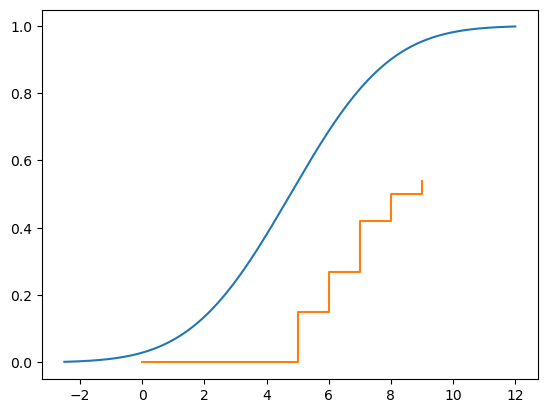

In [54]:
x = np.linspace(-2.5, 12, 1000)
y = [ProbabilityFunctionWrap(i, (np.mean(sample), Sigma(sample))) for i in x]
plt.plot(x, y)


print(new_sample)
counts = Count(new_sample)
print(counts)
heights = Heights(new_sample, 100)
print(heights)
EmpericalFunction(new_sample, x, heights)

In [ ]:
def Hheights(sample, n):
    cur_h = 0
    heights = dict()
    for cur_key in counts:
        frequence = counts[cur_key] / n
        heights[cur_key] = cur_h + frequence
        cur_h += frequence
        
    return heights